#  Load model


In [1]:
import os
import glob
import sys
import numpy as np
import pickle
from sklearn.cluster import KMeans
import tensorflow as tf
import PIL
import ipywidgets
import io
import h5py
from keras.models import load_model
from keras.applications.mobilenet import preprocess_input

""" make sure this notebook is running from root directory """
while os.path.basename(os.getcwd()) in ('notebooks', 'src'):
    os.chdir('..')
assert ('README.md' in os.listdir('./')), 'Can not find project root, please cd to project root before running the following code'

import src.tl_gan.generate_image as generate_image
import src.tl_gan.feature_axis as feature_axis
import src.tl_gan.feature_celeba_organize as feature_celeba_organize

# use gpu 1
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"]='1' 

""" load feature directions """
path_feature_direction = './asset_results/stylegan_ffhq_feature_direction_retrained'

pathfile_feature_direction = glob.glob(os.path.join(path_feature_direction, 'feature_direction_*.pkl'))[-1]

with open(pathfile_feature_direction, 'rb') as f:
    feature_direction_name = pickle.load(f)

feature_direction = feature_direction_name['direction']
feature_name = feature_direction_name['name']
num_feature = feature_direction.shape[1]

import importlib
importlib.reload(feature_celeba_organize)
feature_name = feature_celeba_organize.feature_name_celeba_rename
feature_direction = feature_direction_name['direction']* feature_celeba_organize.feature_reverse[None, :]
""" start tf session and load GAN model """

# path to model code and weight
path_pg_gan_code = './src/model/pggan'
path_model = './network-snapshot-013246.pkl'
sys.path.append(path_pg_gan_code)


""" create tf session """
yn_CPU_only = False

if yn_CPU_only:
    config = tf.ConfigProto(device_count = {'GPU': 0}, allow_soft_placement=True)
else:
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()
try:
    with open(path_model, 'rb') as file:
        G, D, Gs = pickle.load(file)
except FileNotFoundError:
    print('before running the code, download pre-trained model to project_root/asset_model/')
    raise

def img_to_bytes(x_sample):
    imgObj = PIL.Image.fromarray(x_sample)
    imgByteArr = io.BytesIO()
    imgObj.save(imgByteArr, format='PNG')
    imgBytes = imgByteArr.getvalue()
    return imgBytes

model = load_model('model_20180927_032934.h5') #feature extractor

Using TensorFlow backend.













Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









# Setting Features

In [2]:
#features = [8,9,20,21,31,39]
# features = [21]
features = [20,39,8,9,31,21]        # male,age,blond hair,black hair,smiling, mouse open
# features = [20,39,8,9,31,21,15,24]  # male,age,blond hair,black hair,smiling, mouse open, glass, beard
#Beard, Glasses not possible
pm = [-1,1]
centers = np.empty((40,30,2,512)) #no. of features, max no. of clusters, with/without attribute (0,1), dim=512
len_z = Gs.input_shapes[0][1]
for a in features:
    for sign in pm:
        print(feature_name[a])
        print("direction:" + str(sign))
        temp = np.empty((512,0))
        for i in range(5000):
            if i%100==99:
                print(i+1)
            z_sample = np.random.randn(len_z)
            z_arr = np.ndarray.flatten(z_sample)
            x_sample = generate_image.gen_single_img(z=z_arr, Gs=Gs)
            x_byte = img_to_bytes(x_sample)
            x = x_sample[None, :] # batch with 1 image  
            x = x[:, 1::2, 1::2, :] # downsample to 128x128
            x = preprocess_input(x)
            y = model.predict(x)
            if (y[0][a]*sign>=0.8): #scale is from -1 to 1
                temp = np.append(temp, z_arr)
        temp = np.reshape(temp,(-1,512))
        if a == 20:
            kmeans = KMeans(n_clusters=30).fit(temp)
            for i in range(30):
                centers[a][i][(sign+1)//2]=kmeans.cluster_centers_[i]
        else:
            kmeans = KMeans(n_clusters=10).fit(temp)
            for i in range(10):
                centers[a][i][(sign+1)//2]=kmeans.cluster_centers_[i]
        
'''
8: Black Hair
9: Blond Hair
15: Glasses
16: Goatee
20: Male
21: Mouth Open
24: Beard
31: Smiling
39: Age
'''

Male
direction:-1
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Male
direction:1
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Age
direction:-1
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
Age
direction:1
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
440

'\n8: Black Hair\n9: Blond Hair\n15: Glasses\n16: Goatee\n20: Male\n21: Mouth Open\n24: Beard\n31: Smiling\n39: Age\n'

# TSNE-test

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


#from sklearn import manifold, datasets

#features = [8,9,20,21,31,39]
features = [31]
# features = [20,39,8,9,31,21]        # male,age,blond hair,black hair,smiling, mouse open
# features = [20,39,8,9,31,21,15,24]  # male,age,blond hair,black hair,smiling, mouse open, glass, beard
#Beard, Glasses not possible
pm = [-1,1]
centers = np.empty((40,30,2,512)) #no. of features, max no. of clusters, with/without attribute (0,1), dim=512
len_z = Gs.input_shapes[0][1]
for a in features:
    for sign in pm:
        print(feature_name[a])
        print("direction:" + str(sign))
        temp = np.empty((512,0))
        for i in range(5000):
            if i%100==99:
                print(i+1)
            z_sample = np.random.randn(len_z)
            z_arr = np.ndarray.flatten(z_sample)
            x_sample = generate_image.gen_single_img(z=z_arr, Gs=Gs)
            x_byte = img_to_bytes(x_sample)
            x = x_sample[None, :] # batch with 1 image  
            x = x[:, 1::2, 1::2, :] # downsample to 128x128
            x = preprocess_input(x)
            y = model.predict(x)
            if (y[0][a]*sign>=0.8): #scale is from -1 to 1
                temp = np.append(temp, z_arr)
        temp = np.reshape(temp,(-1,512)) #改变维度为d行、512列 （-1表示行数自动计算，d= a*b /m ）
        print(temp)
        if a == 20:
            kmeans = KMeans(n_clusters=30).fit(temp)
            for i in range(30):
                centers[a][i][(sign+1)//2]=kmeans.cluster_centers_[i]
        else:
            kmeans = KMeans(n_clusters=10).fit(temp)
            for i in range(10):
                centers[a][i][(sign+1)//2]=kmeans.cluster_centers_[i]

        #简单打印结果        
        # kmeans <- model
        r1 = pd.Series(kmeans.labels_).value_counts() #统计各个类别的数目
        r2 = pd.DataFrame(kmeans.cluster_centers_) #找出聚类中心
        r = pd.concat([r2,r1],axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目
        print(r)
        

Smiling
direction:-1
100
200


In [58]:
r3 = pd.concat([r2],axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目

r.columns = list(r3.columns) + [u'类别数目'] #重命名表头

print(r)

          0         1         2         3         4         5         6  \
0 -0.019987  0.132900 -0.102886 -0.103101  0.005069 -0.125288 -0.164132   
1  0.193949 -0.081956  0.100975 -0.126646  0.067476 -0.222229  0.289610   
2 -0.082594 -0.114476  0.057653  0.123651  0.020045 -0.013961  0.011676   
3 -0.021847  0.116860 -0.136542  0.154615 -0.234631 -0.086741  0.206736   
4 -0.037685  0.255446 -0.086797 -0.067389 -0.077843 -0.149105  0.102507   
5 -0.055918  0.064993 -0.262975 -0.015257 -0.054295 -0.021815 -0.023448   
6 -0.163064  0.129732 -0.088314  0.110802  0.118916  0.257421 -0.007752   
7  0.122066  0.148274  0.109390 -0.101386  0.017444  0.192422  0.234604   
8  0.148913  0.051093 -0.125525 -0.082099 -0.114705 -0.267557 -0.125246   
9 -0.170274 -0.107544 -0.086897 -0.090250 -0.092613 -0.208463  0.080620   

          7         8         9  ...        503       504       505       506  \
0 -0.134449 -0.065324 -0.201194  ...  -0.000448 -0.049362 -0.124005  0.043722   
1 -0.008840 

In [59]:
#详细输出原始数据及其类别


import numpy as np
import pandas as pd
temp = pd.DataFrame(temp)

r = pd.concat([temp, pd.Series(kmeans.labels_, index = temp.index)], axis = 1)  #详细输出每个样本对应的类别
r.columns = list(temp.columns) + [u'聚类类别'] #重命名表头
# r.to_excel(outputfile) #保存结果
print(r)


             0         1         2         3         4         5         6  \
0    -0.230264  0.665040  0.810740 -0.571512 -0.242917  1.962538 -0.463148   
1     0.508356  1.124907  0.159710  0.016413 -0.210603  0.739349 -0.034655   
2    -0.333141 -2.487558  1.856101 -1.108236 -0.129540 -0.163505  1.181158   
3     0.811843 -0.068029  0.388753 -1.235278 -1.521883  1.493335 -2.113434   
4     0.183268  0.007124  1.705461 -0.508009 -0.274142 -0.291055  0.521193   
5     0.237134 -0.384166 -1.352886  0.028895  0.110615  0.265464 -1.155929   
6     0.977419  0.236592 -0.750036  0.277548  1.772801  1.358712  1.038828   
7    -1.603168 -0.430299 -0.233247 -0.945786  1.958213 -0.599759  0.259947   
8     1.986316  1.447766  0.278835 -1.195763 -0.128811  0.459649  0.881385   
9     1.190168  0.148775 -0.142216  0.118986  0.256946  0.987964 -0.530440   
10   -0.006931  1.727770 -0.601282  2.266199  1.107619  1.580789 -0.298104   
11   -0.718402  1.232766 -0.312662 -0.704675 -1.011399 -0.512748

In [60]:
        tsne=TSNE()
        
        #tsne.fit_transform(temp)  #进行数据降维,降成两维
        tsne.fit_transform(temp) #a是一个array,a相当于下面的tsne_embedding
        tsne=pd.DataFrame(tsne.embedding_,index=temp.index) #转换数据格式
        
        print(tsne)

              0          1
0    -12.906129   6.694590
1     20.192863 -21.021650
2     25.023754   5.484952
3    -26.240953  -7.420072
4    -31.527506  -4.924972
5      9.135132  -6.566767
6     -9.737803  22.374289
7     -8.001948  17.021973
8    -10.242301 -25.333582
9     -2.885716 -24.605608
10    12.275867  -6.545272
11     2.265962  -3.099634
12    28.399895 -20.135670
13    13.827004  -0.276051
14    -4.858368   1.989515
15     2.087042 -10.002834
16     3.126153   1.721583
17     0.735495   2.427330
18    -1.452439  30.291822
19     4.011556 -19.609621
20   -21.519434 -14.639336
21   -26.603363   9.635567
22    15.606169 -14.507148
23    36.544086  -3.324927
24    -9.891365   1.299915
25    10.597123 -25.648624
26    24.261374 -21.891104
27     5.276335   6.862868
28     0.354679  28.862804
29     7.934160  -8.770961
...         ...        ...
1521 -11.431971  -2.851795
1522 -15.540397 -28.740505
1523  18.164553 -27.888779
1524  17.134161 -31.514893
1525 -13.795971 -24.372726
1

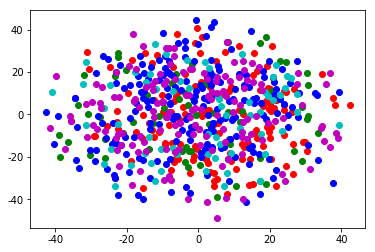

In [62]:
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

#不同类别用不同颜色和样式绘图

# color=['b','g','r','c','m','y','k','w']
# linestyle=['-','--','-.',':']

d = tsne[r[u'聚类类别'] == 0]     #找出聚类类别为0的数据对应的降维结果
plt.plot(d[0], d[1], 'ro')
d = tsne[r[u'聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = tsne[r[u'聚类类别'] == 2]
plt.plot(d[0], d[1], 'bo')
d = tsne[r[u'聚类类别'] == 3]
plt.plot(d[0], d[1], 'co')
d = tsne[r[u'聚类类别'] == 4]
plt.plot(d[0], d[1], 'mo')
# d = tsne[r[u'聚类类别'] == 5]
# plt.plot(d[0], d[1], 'y*')
# d = tsne[r[u'聚类类别'] == 6]
# plt.plot(d[0], d[1], 'k*')
# d = tsne[r[u'聚类类别'] == 7]
# plt.plot(d[0], d[1], 'w*')
# d = tsne[r[u'聚类类别'] == 8]
# plt.plot(d[0], d[1], 'r*')
# d = tsne[r[u'聚类类别'] == 9]
# plt.plot(d[0], d[1], 'g*')
plt.show()


# Generate Random Face

In [3]:
## Generate Random Face
z_sample = np.random.randn(len_z)
x_sample = generate_image.gen_single_img(Gs=Gs)
w_img = ipywidgets.widgets.Image(value=img_to_bytes(x_sample), format='png', 
                                 width=256, height=256,
                                 layout=ipywidgets.Layout(height='256px', width='256px')
                                )

class GuiCallback(object):
    counter = 0
    def __init__(self):
        self.latents = z_sample
        self.feature_direction = feature_direction
        
    def random_gen_feature(self, event, idx_feature, direction):
        #Generate face with/without desired feature
        if idx_feature == 20: 
            rnd = random.randint(0,29)
        else:
            rnd = random.randint(0,9)
        if idx_feature == 39:
            direction = 1 - direction
        self.latents = centers[idx_feature][rnd][direction]+0.2*np.random.randn(len_z)
        self.update_img(idx_feature)       
        
    def random_gen(self, event):
        self.latents = np.random.randn(len_z)
        self.update_img()
    
    def update_img(self, idx_feature=None):
        #print('Distance from mean: {:.2f}'.format(np.linalg.norm(self.latents)))
        x_sample = generate_image.gen_single_img(z=self.latents, Gs=Gs)       
        x_byte = img_to_bytes(x_sample)
        w_img.value = x_byte
        
        x = x_sample[None, :] # batch with 1 image  
        x = x[:, 1::2, 1::2, :] # downsample to 128x128
        x = preprocess_input(x)
        y = model.predict(x)
        if idx_feature is not None:
            if idx_feature in {24, 36, 39}:
                #Reverse direction of feature (e.g. No Beard --> Beard)
                print('{}: {:.2f}'.format(feature_name[idx_feature],-y[0][idx_feature]))
            else:
                print('{}: {:.2f}'.format(feature_name[idx_feature],y[0][idx_feature]))
   

guicallback = GuiCallback()

def create_button(idx_feature, width=96, height=40):
    """ function to built button groups for one feature """
    w_name_toggle = ipywidgets.widgets.ToggleButton(
        value=False, description=feature_name[idx_feature],
        tooltip='{}, Press down to lock this feature'.format(feature_name[idx_feature]),
        layout=ipywidgets.Layout(height='{:.0f}px'.format(height/2), 
                                 width='{:.0f}px'.format(width),
                                 margin='2px 2px 2px 2px')
    )
    
    w_no = ipywidgets.widgets.Button(description='no',
                                      layout=ipywidgets.Layout(height='{:.0f}px'.format(height/2), 
                                                               width='{:.0f}px'.format(width/2),
                                                               margin='1px 1px 5px 1px'))
    w_yes = ipywidgets.widgets.Button(description='yes',
                                      layout=ipywidgets.Layout(height='{:.0f}px'.format(height/2), 
                                                               width='{:.0f}px'.format(width/2),
                                                               margin='1px 1px 5px 1px'))

    w_no.on_click(lambda event: guicallback.random_gen_feature(event, idx_feature, 0))
    w_yes.on_click(lambda event: guicallback.random_gen_feature(event, idx_feature, +1))
    
    button_group = ipywidgets.VBox([w_name_toggle, ipywidgets.VBox([ipywidgets.HBox([w_yes, w_no])])],
                                  layout=ipywidgets.Layout(border='1px solid gray'))
    
    return button_group
  

list_buttons = []
for idx_feature in range(num_feature):
    list_buttons.append(create_button(idx_feature))

yn_button_select = True #Filtered Attributes only
def arrange_buttons(list_buttons, ncol=4):
    feature_celeba_layout = feature_celeba_organize.feature_celeba_layout
    return ipywidgets.VBox([ipywidgets.HBox([list_buttons[item] for item in row]) for row in feature_celeba_layout])
    
    
guicallback.update_img()
w_button_random = ipywidgets.widgets.Button(description='random face', button_style='success',
                                           layout=ipywidgets.Layout(height='40px', 
                                                               width='168px',
                                                               margin='1px 1px 5px 1px'))
w_button_random.on_click(guicallback.random_gen)

w_box = ipywidgets.HBox([w_img, 
                         ipywidgets.VBox([w_button_random, 
                                         arrange_buttons(list_buttons)])
                        ], layout=ipywidgets.Layout(height='300px', width='700px')
                       )

print('Select yes/no to generate faces with/without the feature')
print('Note: model not yet trained for "eyeglasses" and "beard"')
display(w_box)


Select yes/no to generate faces with/without the feature
Note: model not yet trained for "eyeglasses" and "beard"


NameError: name 'random' is not defined

NameError: name 'random' is not defined

NameError: name 'random' is not defined

NameError: name 'random' is not defined

NameError: name 'random' is not defined

NameError: name 'random' is not defined